In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications import NASNetMobile
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report
import keras_tuner as kt

In [2]:
# Define directories
train_dir = 'E:/IIT/Lectures/4 Year/FYP/Dataset/80 FYP Dataset 2 class/Training dataset'
test_dir = 'E:/IIT/Lectures/4 Year/FYP/Dataset/80 FYP Dataset 2 class/Testing dataset'
validation_dir = 'E:/IIT/Lectures/4 Year/FYP/Dataset/80 FYP Dataset 2 class/Validation dataset'

In [3]:
# To get classes with labels from a directory
def get_classes_with_labels(directory):
    classes = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    classes.sort()  # Sort to ensure consistent labeling
    return {cls: idx for idx, cls in enumerate(classes)}

# Get classes with labels for each directory
train_classes_with_labels = get_classes_with_labels(train_dir)
test_classes_with_labels = get_classes_with_labels(test_dir)
validation_classes_with_labels = get_classes_with_labels(validation_dir)

# Print classes and their labels for each directory
print("Training classes with labels:", train_classes_with_labels)
print("Testing classes with labels:", test_classes_with_labels)
print("Validation classes with labels:", validation_classes_with_labels)

Training classes with labels: {'Keratoconus': 0, 'Normal': 1}
Testing classes with labels: {'Keratoconus': 0, 'Normal': 1}
Validation classes with labels: {'Keratoconus': 0, 'Normal': 1}


**Exploratory Data Analysis**

=== Exploratory Data Analysis ===


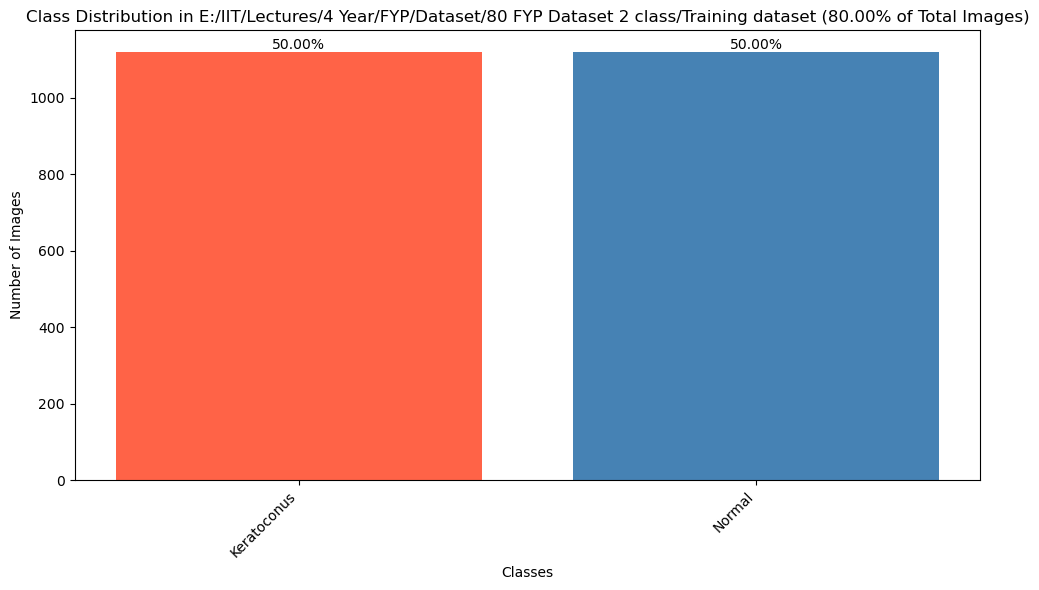


Directory: E:/IIT/Lectures/4 Year/FYP/Dataset/80 FYP Dataset 2 class/Training dataset
Total classes: 2
Class distribution with counts and percentages:
Keratoconus: 1120 images, 50.00%
Normal: 1120 images, 50.00%
Total images in E:/IIT/Lectures/4 Year/FYP/Dataset/80 FYP Dataset 2 class/Training dataset: 2240 (80.00% of all images)


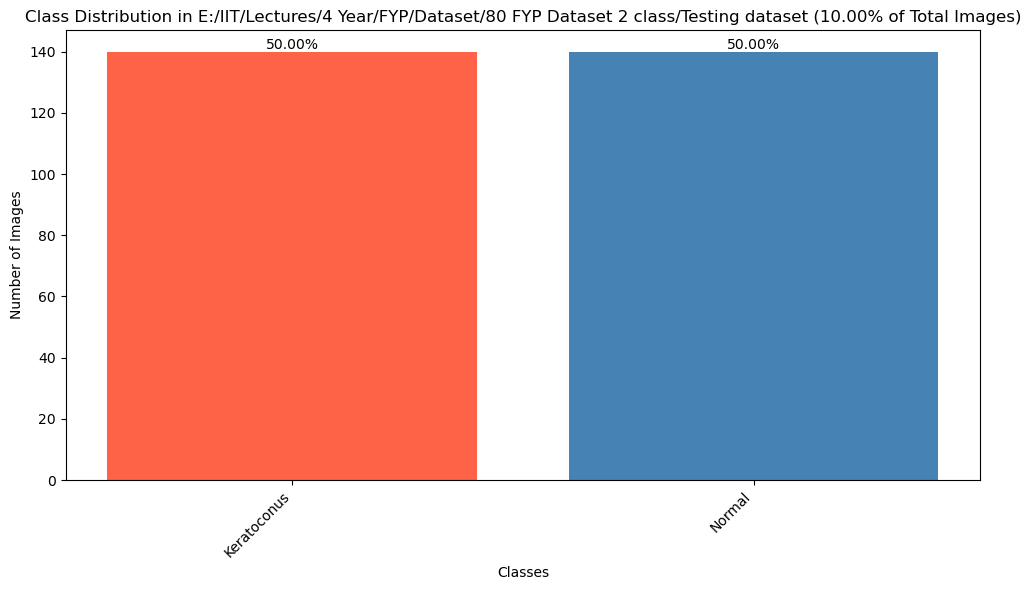


Directory: E:/IIT/Lectures/4 Year/FYP/Dataset/80 FYP Dataset 2 class/Testing dataset
Total classes: 2
Class distribution with counts and percentages:
Keratoconus: 140 images, 50.00%
Normal: 140 images, 50.00%
Total images in E:/IIT/Lectures/4 Year/FYP/Dataset/80 FYP Dataset 2 class/Testing dataset: 280 (10.00% of all images)


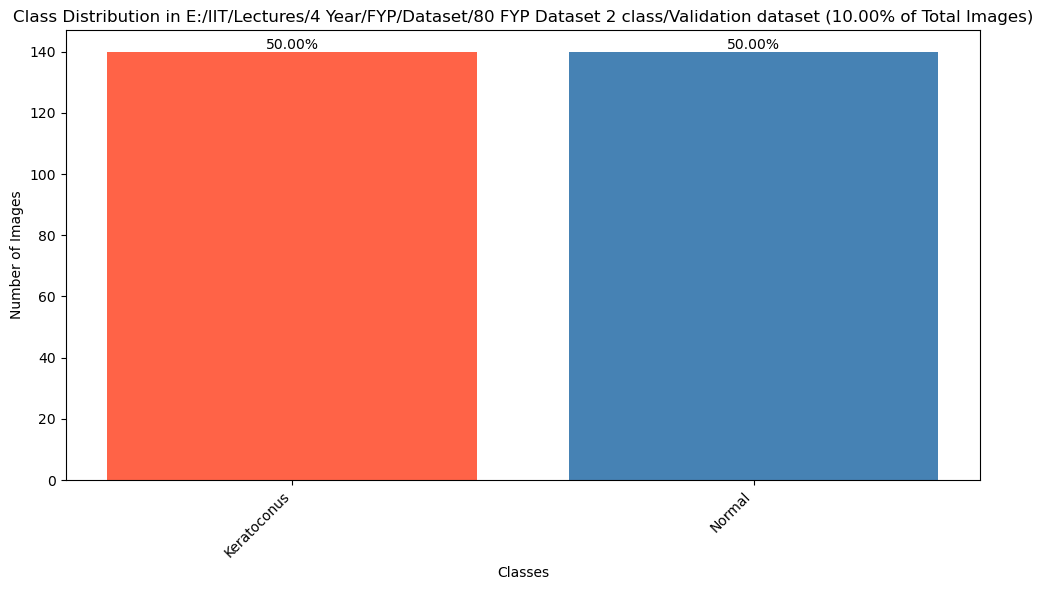


Directory: E:/IIT/Lectures/4 Year/FYP/Dataset/80 FYP Dataset 2 class/Validation dataset
Total classes: 2
Class distribution with counts and percentages:
Keratoconus: 140 images, 50.00%
Normal: 140 images, 50.00%
Total images in E:/IIT/Lectures/4 Year/FYP/Dataset/80 FYP Dataset 2 class/Validation dataset: 280 (10.00% of all images)


In [5]:
def analyze_classes_and_visualize(directory, total_images_across_all_datasets):
    if not os.path.isdir(directory):
        raise FileNotFoundError(f"Directory not found: {directory}")

    # Get class directories
    class_dirs = os.listdir(directory)
    class_dirs.sort()

    # Count images per class
    class_counts = {}
    total_images = 0
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            num_images = sum([len(files) for _, _, files in os.walk(class_path)])
            class_counts[class_dir] = num_images
            total_images += num_images

    # Calculate the percentage of each class in this directory
    class_percentages = {class_name: (count / total_images) * 100 for class_name, count in class_counts.items()}

    # Calculate the percentage of this directory's total images relative to the total number of images across all datasets
    directory_percentage = (total_images / total_images_across_all_datasets) * 100

    # Visualize the class distribution as a bar chart with percentages
    colors = ['#FF6347', '#4682B4']  # Adjusted for two classes
    plt.figure(figsize=(10, 6))
    bars = plt.bar(class_counts.keys(), class_counts.values(), color=colors[:len(class_counts)])
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title(f'Class Distribution in {directory} ({directory_percentage:.2f}% of Total Images)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Add percentage labels on top of bars
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{class_percentages[list(class_counts.keys())[i]]:.2f}%',
                 ha='center', va='bottom', color='black')

    plt.show()

    # Print the class distribution with percentages
    print(f"\nDirectory: {directory}")
    print(f"Total classes: {len(class_counts)}")
    print(f"Class distribution with counts and percentages:")
    for class_name in class_counts:
        print(f"{class_name}: {class_counts[class_name]} images, {class_percentages[class_name]:.2f}%")
    print(f"Total images in {directory}: {total_images} ({directory_percentage:.2f}% of all images)")

    return class_counts, total_images, class_percentages

# Perform EDA on datasets and plot class distribution with percentages
def perform_eda(train_dir, test_dir, validation_dir):
    print("=== Exploratory Data Analysis ===")

    # Calculate total number of images across all datasets
    total_images_across_all_datasets = 0
    for directory in [train_dir, test_dir, validation_dir]:
        total_images_across_all_datasets += sum([len(files) for _, _, files in os.walk(directory)])

    # Analyze and visualize training dataset
    analyze_classes_and_visualize(train_dir, total_images_across_all_datasets)

    # Analyze and visualize testing dataset
    analyze_classes_and_visualize(test_dir, total_images_across_all_datasets)

    # Analyze and visualize validation dataset
    analyze_classes_and_visualize(validation_dir, total_images_across_all_datasets)

# Run EDA
perform_eda(train_dir, test_dir, validation_dir)

**Preprocess the Data**

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.15,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    channel_shift_range=0.1,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Print total augmented images
print(f"Total images in augmented training set: {len(train_generator.filenames)}")

Found 2240 images belonging to 2 classes.
Found 280 images belonging to 2 classes.
Found 280 images belonging to 2 classes.
Total images in augmented training set: 2240


**Model creation**

In [9]:
# Define the model-building function for hyperparameter tuning
def build_model(hp):
    base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze layers
    freeze_percentage = hp.Float('freeze_percentage', 0.4, 0.8, step=0.1)
    total_layers = len(base_model.layers)
    for layer in base_model.layers[:int(total_layers * freeze_percentage)]:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Allow a variable number of dense layers
    num_layers = hp.Int('num_layers', min_value=1, max_value=5, step=1)
    for i in range(num_layers):
        units = hp.Int(f'units_{i}', min_value=32, max_value=256, step=32)
        l2_reg = hp.Choice(f'l2_regularizer_{i}', [0.0001, 0.0005, 0.001])
        dropout_rate = hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.05)
        
        x = Dense(units, kernel_regularizer=l2(l2_reg))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(dropout_rate)(x)
    
    output = Dense(1, activation='sigmoid')(x)

    # Compile model
    model = Model(inputs=base_model.input, outputs=output)

    learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate, clipnorm=0.7),
        loss='binary_crossentropy',
        metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
    )

    return model

In [10]:
# Hyperparameter tuner setup
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='E:/IIT/Lectures/4 Year/FYP/Model/nasnet_tuning',
    project_name='keratoconus_detection_3'
)

In [11]:
# Early stopping and checkpoints
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.0008),
    ModelCheckpoint(filepath='NASNet_checkpoint_tuned_model_3.keras', monitor='val_loss', save_best_only=True, mode='min')
]

In [12]:
# Run tuner search
tuner.search(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=callbacks
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")

Trial 10 Complete [05h 19m 14s]
val_accuracy: 0.9464285969734192

Best val_accuracy So Far: 0.9607142806053162
Total elapsed time: 1d 07h 14m 29s
Best Hyperparameters:
freeze_percentage: 0.6000000000000001
num_layers: 2
units_0: 256
l2_regularizer_0: 0.0001
dropout_0: 0.25
learning_rate: 0.0001
units_1: 256
l2_regularizer_1: 0.0005
dropout_1: 0.35000000000000003
units_2: 192
l2_regularizer_2: 0.0001
dropout_2: 0.35000000000000003
units_3: 96
l2_regularizer_3: 0.0001
dropout_3: 0.4
units_4: 64
l2_regularizer_4: 0.0005
dropout_4: 0.35000000000000003


**Train the Best Model**

In [14]:
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 552s 6s/step - accuracy: 0.6595 - auc: 0.7234 - loss: 0.8331 - precision: 0.6249 - recall: 0.8395 - val_accuracy: 0.6464 - val_auc: 0.7020 - val_loss: 0.8207 - val_precision: 0.5981 - val_recall: 0.8929
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 398s 6s/step - accuracy: 0.8531 - auc: 0.9292 - loss: 0.5138 - precision: 0.8457 - recall: 0.8744 - val_accuracy: 0.6607 - val_auc: 0.7864 - val_loss: 0.9044 - val_precision: 0.5966 - val_recall: 0.9929
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 395s 6s/step - accuracy: 0.8998 - auc: 0.9619 - loss: 0.4159 - precision: 0.8985 - recall: 0.9110 - val_accuracy: 0.6821 - val_auc: 0.8672 - val_loss: 0.9089 - val_precision: 0.6114 - val_recall: 1.0000
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 394s 6s/step - accuracy: 0.9383 - auc: 0.9809 - loss: 0.3397 - precision: 0.9286 - recall: 0.9484 - val_accuracy: 0.7071 - val_auc: 0.8900 - val_loss: 0.8656 - val_precision: 0.6306 - val_recall: 1.0000
Epoch 5/100
70/70 ━━━━━━━━━━━━━━

**Plot Metrics**

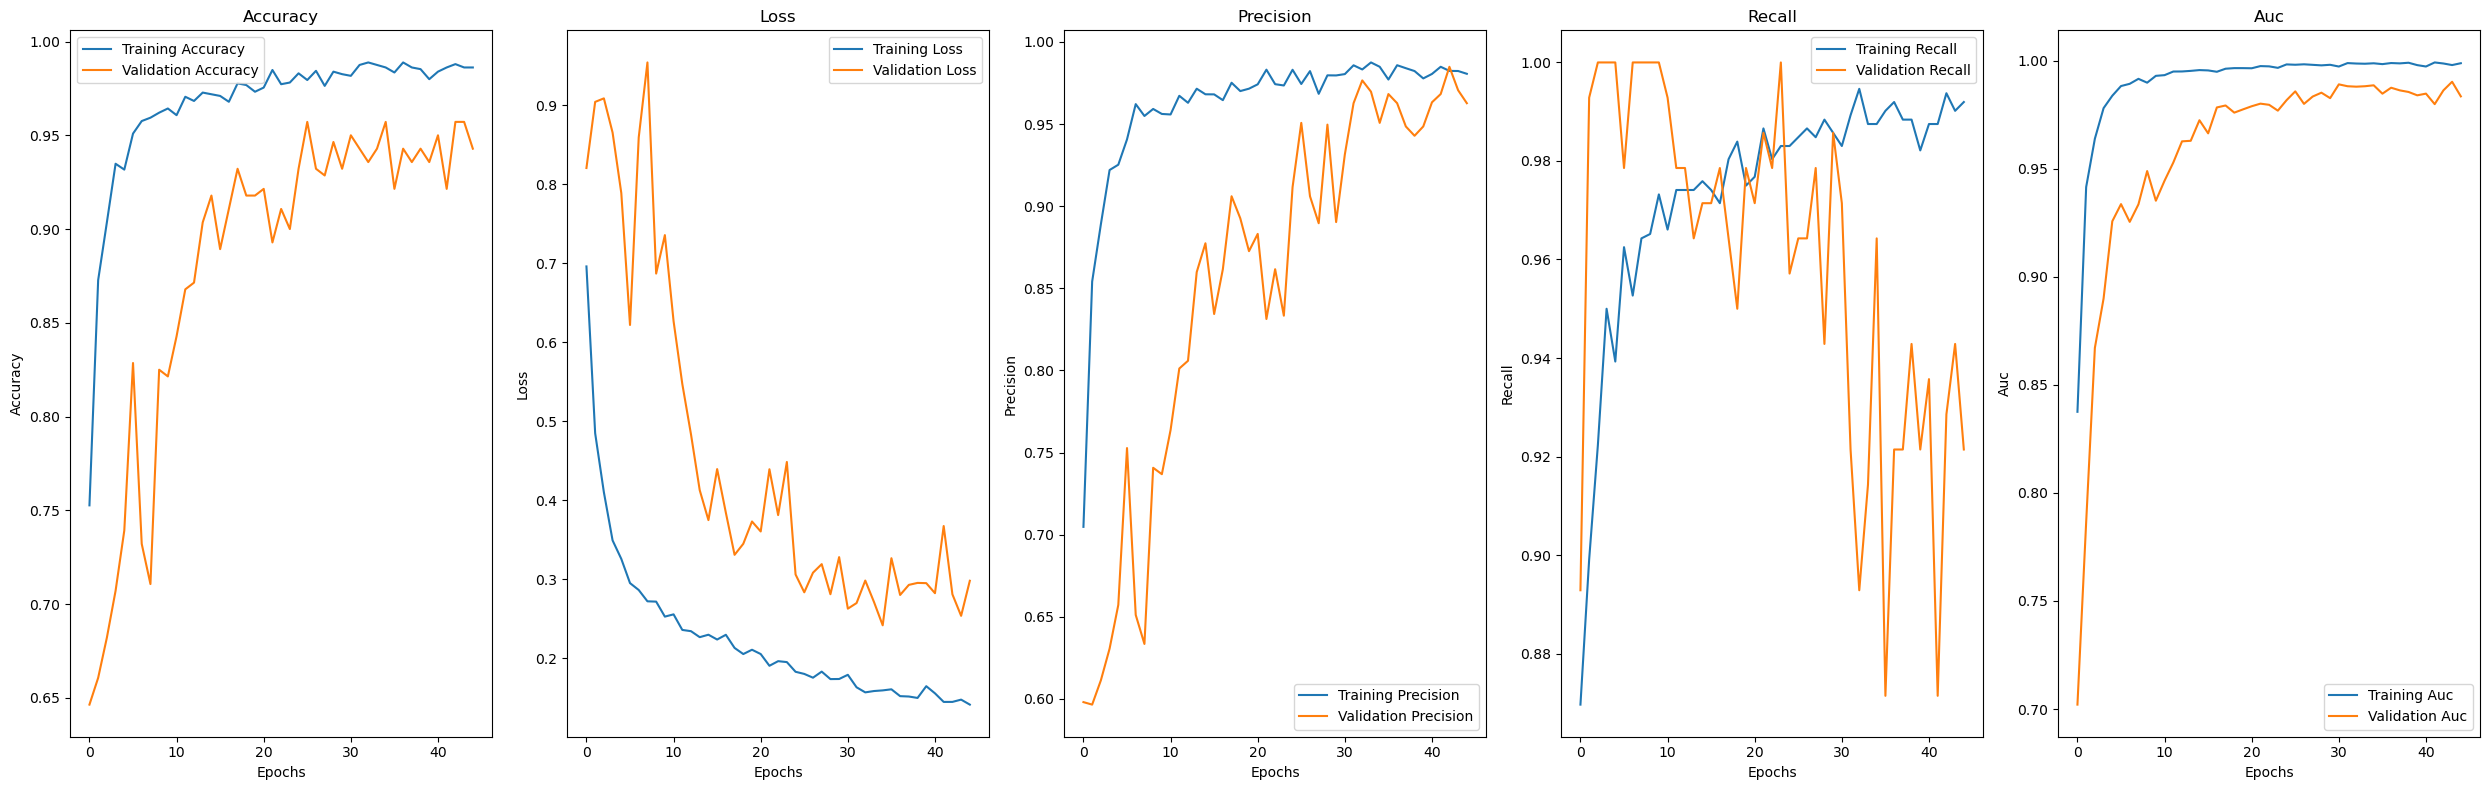

In [16]:
# Plot metrics
metrics = ['accuracy', 'loss', 'precision', 'recall', 'auc']
plt.figure(figsize=(25, 8))
for i, metric in enumerate(metrics):
    plt.subplot(1, 5, i + 1)
    plt.plot(history.history[metric], label=f'Training {metric.capitalize()}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.title(metric.capitalize())

plt.tight_layout()
plt.show()

**Evaluate on Test Data**

In [18]:
evaluation = best_model.evaluate(test_generator)

# Print Evaluation Metrics
print("\nTest Evaluation Metrics:")
for metric_name, metric_value in zip(best_model.metrics_names, evaluation):
    print(f"{metric_name}: {metric_value:.4f}")

# Explicitly print key metrics if needed
if len(evaluation) >= 5:  # Ensure there are enough values
    print(f"\nLoss: {evaluation[0]:.4f}")
    print(f"Accuracy: {evaluation[1]:.4f}")
    print(f"AUC: {evaluation[2]:.4f}")
    print(f"Precision: {evaluation[3]:.4f}")
    print(f"Recall: {evaluation[4]:.4f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - accuracy: 0.9480 - auc: 0.5885 - loss: 0.2934 - precision: 0.5177 - recall: 0.5888   

Test Evaluation Metrics:
loss: 0.2701
compile_metrics: 0.9536

Loss: 0.2701
Accuracy: 0.9536
AUC: 0.9320
Precision: 0.9786
Recall: 0.9815


9/9 ━━━━━━━━━━━━━━━━━━━━ 45s 4s/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      0.93      0.95       140
 Keratoconus       0.93      0.98      0.95       140

    accuracy                           0.95       280
   macro avg       0.95      0.95      0.95       280
weighted avg       0.95      0.95      0.95       280



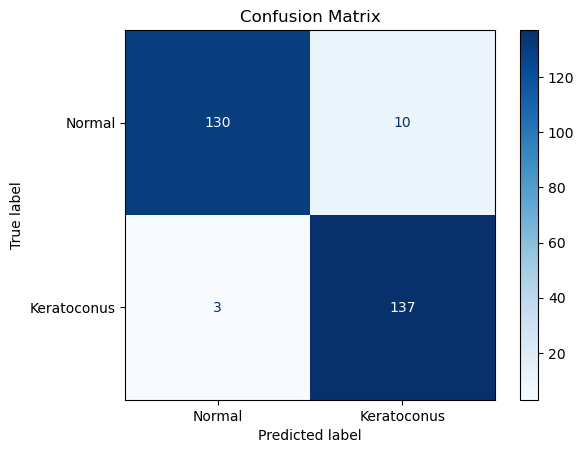

In [19]:
# Test classification report and confusion matrix
y_true = test_generator.classes
y_pred_probs = best_model.predict(test_generator)
y_pred = np.round(y_pred_probs).astype(int)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Keratoconus']))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Keratoconus']).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

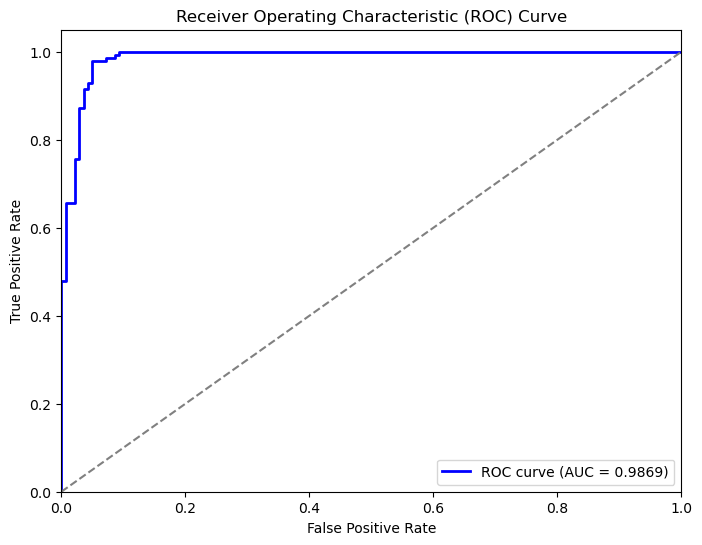

In [20]:
# Compute ROC curve and AUC score
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)  # Use predicted probabilities, not binary labels
roc_auc = auc(fpr, tpr)

# Plot AUC-ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

**Save the Final Model**

In [22]:
best_model.save('E:/IIT/Lectures/4 Year/FYP/Model/NASNet/Final_tuned_3.keras')